In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

Koneksi ke Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/Deteksi Stunting/dataset_tinggi_balita.csv")
df

Mounted at /content/drive


,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.5,stunted
1,0,laki-laki,56.7,tinggi
2,0,laki-laki,46.8,normal
3,0,laki-laki,47.5,normal
4,0,laki-laki,42.7,severely stunted
...,...,...,...,...
120994,60,perempuan,100.6,normal
120995,60,perempuan,98.3,stunted
120996,60,perempuan,121.3,normal
120997,60,perempuan,112.2,normal


**Pengkodean (mapping) jenis kelamin dan status gizi**

In [3]:
df['Jenis Kelamin'] = df['Jenis Kelamin'].map({'laki-laki': 0, 'perempuan': 1})

df['Status Gizi'] = df['Status Gizi'].map({'severely stunted': 0, 'stunted': 1, 'normal': 2, 'tinggi': 3})
df

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,0,44.5,1
1,0,0,56.7,3
2,0,0,46.8,2
3,0,0,47.5,2
4,0,0,42.7,0
...,...,...,...,...
120994,60,1,100.6,2
120995,60,1,98.3,1
120996,60,1,121.3,2
120997,60,1,112.2,2


In [4]:
X = df.iloc[:, 1:6]
X = df.drop('Status Gizi', axis=1)
y = df['Status Gizi']


**Membagi dataset menjadi data training dan testing**

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm)
0,0,0,44.5
1,0,0,56.7
2,0,0,46.8
3,0,0,47.5
4,0,0,42.7
...,...,...,...
120994,60,1,100.6
120995,60,1,98.3
120996,60,1,121.3
120997,60,1,112.2


In [6]:
#Training
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Langkah pertama: scaling fitur
    ('svm', SVC(kernel='rbf', C=10, gamma=5, decision_function_shape='ovo'))  # Langkah kedua: model SVM
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List untuk menyimpan nilai akurasi setiap fold
accuracy_scores = []

# Lakukan cross-validation
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Latih pipeline pada data pelatihan fold
    pipeline.fit(X_train_fold, y_train_fold)

    # Prediksi pada data validasi fold
    y_pred_fold = pipeline.predict(X_val_fold)

    # Evaluasi kinerja model
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    accuracy_scores.append(accuracy_fold)

# Cetak nilai akurasi setiap fold
for i, accuracy_fold in enumerate(accuracy_scores):
    print(f"Fold {i+1} Accuracy: {accuracy_fold * 100:.2f}%")

# Cetak rata-rata akurasi
print(f"Mean Accuracy: {sum(accuracy_scores) / len(accuracy_scores)* 100:.2f}%")

print(classification_report(y_val_fold.values.reshape(-1, 1), y_pred_fold))
print(f"Akurasi model: {accuracy_fold * 100:.2f}%")


Fold 1 Accuracy: 99.60%
Fold 2 Accuracy: 99.46%
Fold 3 Accuracy: 99.46%
Fold 4 Accuracy: 99.42%
Fold 5 Accuracy: 99.50%
Mean Accuracy: 99.49%
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3147
           1       0.99      0.98      0.99      2205
           2       1.00      1.00      1.00     10875
           3       1.00      0.99      0.99      3132

    accuracy                           1.00     19359
   macro avg       0.99      0.99      0.99     19359
weighted avg       1.00      1.00      1.00     19359

Akurasi model: 99.50%


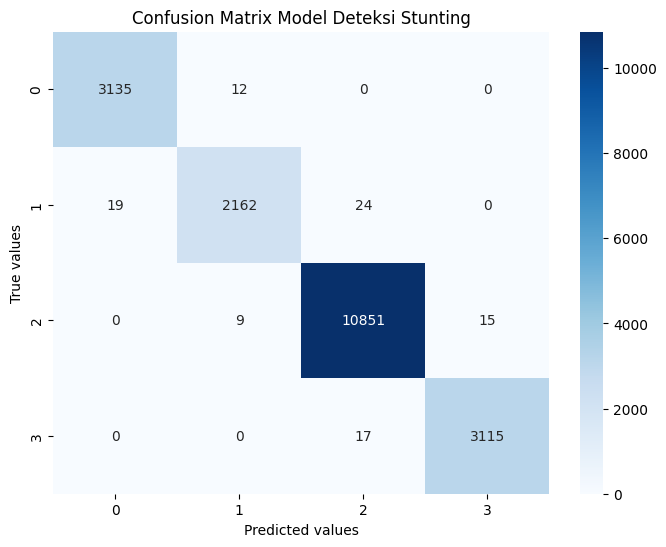

In [7]:

cm = confusion_matrix(y_val_fold, y_pred_fold)

plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion Matrix Model Deteksi Stunting')
plt.show()

In [18]:
import joblib

model_path = '/content/drive/My Drive/Deteksi Stunting/model_deteksi_stunting.pkl'

joblib.dump(pipeline, model_path)

['/content/drive/My Drive/Deteksi Stunting/model_deteksi_stunting.pkl']

In [20]:
import joblib
from sklearn.model_selection import cross_val_score
model_path = '/content/drive/My Drive/Deteksi Stunting/model_deteksi_stunting.pkl'

test_model = joblib.load(model_path)

test_model_stunting = pd.DataFrame({'Umur (bulan)': [45], 'Jenis Kelamin': [0], 'Tinggi Badan (cm)': [130]})

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

pred = pipeline.predict(test_model_stunting)
print("Predicted Score = {}".format(np.array(pred)))



Training Accuracy: 0.9953925143854792
Test Accuracy: 0.9945454545454545
Predicted Score = [3]
